# Exploring Vector Operations

In [1]:
# --- Core scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import Lasso
import umap

# --- Chemistry (RDKit) ---
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import RDLogger

# Suppress RDKit warnings
import warnings
warnings.filterwarnings('ignore')
RDLogger.logger().setLevel(RDLogger.CRITICAL)
import logging
logger = logging.getLogger('my_application')
logger.setLevel(logging.DEBUG)

fh = logging.FileHandler('my_log_file.log')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

# Does not write to sys.stderr
logger.info("These logs do not show up on Jupyter!")

# --- Deep learning / Fairseq ---
from fairseq_utils import preprocess_series, load_dataset, load_model, get_embeddings
from fairseq.data import Dictionary

# --- Project constants ---
from constants import (
    TOKENIZER_SUFFIXES,
    TOKENIZER_PATH,
    FAIRSEQ_PREPROCESS_PATH,
    PROJECT_PATH,
    PREDICTION_MODEL_PATH,
    TASK_PATH
)

# --- Visualization / Display ---
from PIL import Image
from IPython.display import display, HTML, Image as IPyImage
import matplotlib.offsetbox as offsetbox

# --- Utilities ---
import io
import re
import base64
from typing import Dict, List, Tuple, Any
from html import escape

# --- Other ---
import cairosvg

from pathlib import Path

/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-29 16:27:09 | WARNING | deepchem.models | Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
2025-08-29 16:27:09 | WARNING | deepchem.models.torch_models | Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
2025-08-29 16:27:09 | WARNING | deepchem.models | Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/fairseq_git2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
2025-08-29 16:27:09 | WARNING | deepchem.models | Skipped loading modules with pytorch-lightnin

In [2]:
print(PROJECT_PATH)

/scratch/tlemmin/SoS/SMILES_or_SELFIES


In [3]:
def embed_all(path, cuda=0):
    output_dict = dict()
    for model_type in ["roberta", 'bart', 'untrained']:
        tokenizer_dict = dict()
        if model_type!='untrained':
            for tokenizer_suffix in TOKENIZER_SUFFIXES:
                tokenizer_dict[tokenizer_suffix] = embed(path, model_type, tokenizer_suffix, cuda)
        elif model_type=='untrained':
            for tokenizer_suffix in ['smiles_atom_isomers','selfies_atom_isomers']:
                tokenizer_dict[tokenizer_suffix] = embed(path, model_type, tokenizer_suffix, cuda)
        output_dict[model_type] = tokenizer_dict 
    return output_dict

def embed(path, model_type, tokenizer_suffix, cuda):
    model_suffix = tokenizer_suffix+"_"+model_type
    fairseq_dict_path = TASK_PATH / "bbbp" /tokenizer_suffix
    if model_type=='untrained':
        pretrained_TASK_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models")
        model_path = pretrained_TASK_MODEL_PATH / f"untrained_{tokenizer_suffix}" / "checkpoint_last.pt"
    else:
        model_path = PREDICTION_MODEL_PATH/model_suffix/"checkpoint_last.pt"
    dataset_path = (path / tokenizer_suffix/ "input0")
    model = load_model(model_path,fairseq_dict_path,str(cuda))

    dataset = load_dataset(dataset_path/"train")
    source_dictionary = Dictionary.load(str(dataset_path/"dict.txt"))
    embeddings = get_embeddings(model, dataset, source_dictionary, whole_mol=True, cuda=1)
    return embeddings


In [ ]:
smiles_to_name = {
    # Alkanes (n-alkanes and branched isomers)
    "C": "Methane",
    "CC": "Ethane",
    "CCC": "Propane",
    "CCCC": "Butane",
    "CC(C)C": "Isobutane",  # 2-methylpropane
    "CCCCC": "Pentane",
    "CC(C)CC": "Isopentane",  # 2-methylbutane
    "CC(C)(C)C": "Neopentane",  # 2,2-dimethylpropane
    "CCCCCC": "Hexane",
    "CC(C)CCC": "2-Methylpentane",
    "CC(C)C(C)C": "2,3-Dimethylbutane",
    "C(C)(C)CCC": "3-Methylpentane",
    "C(C)(C)C(C)C": "2,2-Dimethylbutane",
    "CCCCCCC": "Heptane",
    
    # Alkenes
    
    
    
    
    # Alkines

    # Alcohols (-OH)
    'CO': 'Methanol',
    'CCO': 'Ethanol',
    'CCCO': '1-Propanol',
    'CC(O)C': '2-Propanol',  # Isopropanol (renamed for consistency)
    'CCCCO': '1-Butanol',
    'CC(O)CC': '2-Butanol',
    'CC(C)CO': 'Isobutanol',  # 2-methyl-1-propanol
    'CC(C)(C)O': 'tert-Butanol',
    'CCCCCO': '1-Pentanol',
    'CCCC(O)C': '2-Pentanol',
    'CCCCCCO': '1-Hexanol',
    'CCCCCCCCO': '1-Heptanol',
    
    # Aldehydes (-CHO)
    'C=O': 'Formaldehyde',
    'CC=O': 'Acetaldehyde',
    'CCC=O': 'Propanal',
    'CCCC=O': 'Butanal',
    'CCCCC=O': 'Pentanal',
    'CCCCCC=O': 'Hexanal',
    'CCCCCCC=O': 'Heptanal',

    # Ketones (R-C(=O)-R')
    'CC(C)=O': 'Acetone',
    'CCC(=O)C': '2-Butanone',
    'CC(=O)CC': '2-Butanone', # A common alternative SMILES
    'CCCC(=O)C': '2-Pentanone',
    'CC(=O)CCC': '2-Pentanone',
    'CCC(=O)CC': '3-Pentanone',

    # Carboxylic Acids (-COOH)
    'O=CO': 'Formic acid',
    'CC(=O)O': 'Acetic acid',
    'CCC(=O)O': 'Propionic acid',
    'CCCC(=O)O': 'Butyric acid',
    'CCCCC(=O)O': 'Valeric acid',
    'CCCCCC(=O)O': 'Hexanoic acid',
    'CCCCCCC(=O)O': 'Heptanoic acid',

    # Ethers (R-O-R')
    'COC': 'Dimethyl ether',
    'COCC': 'Ethyl methyl ether',
    'CCOCC': 'Diethyl ether',

    # Esters (R-C(=O)O-R')
    'COC=O': 'Methyl formate',
    'CCOC=O': 'Ethyl formate',
    'CC(=O)OC': 'Methyl acetate',
    'CC(=O)OCC': 'Ethyl acetate',
    'CCC(=O)OC': 'Methyl propanoate',
    'CC(=O)CCC': 'Propyl acetate',

    # Halogenated Hydrocarbons
    'CCl': 'Chloromethane',
    'C(Cl)Cl': 'Dichloromethane',
    'C(Cl)(Cl)Cl': 'Chloroform',
    'C(Cl)(Cl)(Cl)Cl': 'Carbon tetrachloride',
    'CCCl': 'Chloroethane',
    'CCCCl': '1-Chloropropane',
    'CC(Cl)C': '2-Chloropropane',
}

molecule_smiles = [s for s in smiles_to_name.keys()]

In [6]:
latent_geometry_path = PROJECT_PATH/"latent_space_geometry"
print(latent_geometry_path)
print(PROJECT_PATH)
#preprocess_series(molecule_smiles, latent_geometry_path)

/scratch/tlemmin/SoS/SMILES_or_SELFIES/latent_space_geometry
/scratch/tlemmin/SoS/SMILES_or_SELFIES


In [7]:
embeddings_dict = embed_all(latent_geometry_path, 1)

2025-08-29 16:30:19 | INFO | fairseq.file_utils | loading archive file /scratch/tlemmin/SoS/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_roberta
2025-08-29 16:30:19 | INFO | fairseq.file_utils | loading archive file /scratch/tlemmin/SoS/SMILES_or_SELFIES/task/bbbp/smiles_atom_isomers
2025-08-29 16:30:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-08-29 16:30:24 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001,

In [39]:
print(embeddings_dict.keys())
print(embeddings_dict['untrained'].keys())

dict_keys(['roberta', 'bart', 'untrained'])
dict_keys(['smiles_atom_isomers', 'selfies_atom_isomers'])


In [8]:
embeddings = embeddings_dict['bart']['selfies_atom_standard'] 

In [40]:
def mol_to_img_scaled(mol, size=(60, 60), bondLength=20):
    """
    Draw a molecule at a fixed visual scale (all molecules appear the same size)
    with a transparent background.
    """
    # Compute 2D coordinates
    Chem.rdDepictor.Compute2DCoords(mol)

    # Get atom coordinates
    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i))[:2] for i in range(mol.GetNumAtoms())])

    # Rescale coordinates to fit in a [0,1] x [0,1] box
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    scale = max(max_coords - min_coords)
    coords_scaled = (coords - min_coords) / scale  # coordinates now in 0-1

    # Update the molecule's coordinates
    for i in range(mol.GetNumAtoms()):
        x, y = coords_scaled[i]
        conf.SetAtomPosition(i, Chem.rdGeometry.Point3D(x, y, 0))

    # Draw molecule using Cairo
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
    drawer.drawOptions().bondLineWidth = 1.5
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()

    # Get PNG and convert to PIL image with transparency
    png_bytes = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png_bytes))
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    
    return img

# -----------------------------------------------------------------------------
# Function to plot 2D embeddings
# -----------------------------------------------------------------------------
def plot_2d_embeddings(embeddings_dict, method='UMAP', smiles=None):
    """
    Reduces the dimensionality of a set of embeddings and plots them in 2D.

    This function takes a dictionary of molecule names and their embeddings,
    performs dimensionality reduction using either PCA or UMAP, and then
    creates a scatter plot with labels for each molecule.

    Args:
        embeddings_dict (dict): A dictionary mapping molecule names (str)
                                to their embedding vectors (np.array).
        method (str): The dimensionality reduction method to use.
                      Options are 'PCA' or 'UMAP'. Default is 'UMAP'.
    """
    # Extract labels and embeddings from the dictionary
    labels = list(embeddings_dict.keys())
    embeddings = np.array(list(embeddings_dict.values()))

    # Choose the dimensionality reduction method
    if method == 'PCA':
        print("\nPerforming PCA for dimensionality reduction...")
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(embeddings)
    elif method == 'UMAP':
        print("\nPerforming UMAP for dimensionality reduction...")
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords = reducer.fit_transform(embeddings)
    else:
        print(f"Invalid method: '{method}'. Defaulting to UMAP.")
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords = reducer.fit_transform(embeddings)
    #print(coords)
    # Plot the 2D embeddings
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.scatter(coords[:, 0], coords[:, 1], s=0)  # optional tiny points as placeholders

    for i, (s, c) in enumerate(zip(smiles, coords)):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Draw molecule to PIL image
            img = Draw.MolToImage(mol, size=(60, 60), bondMin=2.0, bondMax=2.5)
            im = offsetbox.OffsetImage(img, zoom=0.7)  # adjust zoom to scale image
            ab = offsetbox.AnnotationBbox(im, c, frameon=False)
            ax.add_artist(ab)
    
    # Add text labels for each point
    for i, label in enumerate(labels):
        plt.text(coords[i, 0] + 0.05, coords[i, 1] + 0.05, label, fontsize=9)

    plt.title(f"{method} Projection of Molecular Embeddings", fontsize=16)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

In [41]:
embedding_dict = {}

for i, name in enumerate(smiles_to_name.values()):
    embedding_dict[name] = embeddings[i]
plot_2d_embeddings(embedding_dict, method='UMAP', smiles=molecule_smiles)

NameError: name 'embeddings' is not defined

In [10]:
def check_and_filter_non_trivial_operations(
    operations: List[Tuple[str, str, str, str]],
    embeddings_dict: Dict[str, Dict[str, np.ndarray]],
    smiles_to_name: Dict[str, str],
    models: List[Tuple[str, str]],
    magnitude_threshold: float = 1e-6
) -> Dict[str, List]:
    """
    Checks operations for triviality across all models and returns a comprehensive
    dictionary detailing the results.

    The returned dictionary has two main keys:
    'non_trivial_operations': A list of operations that passed all checks for all models.
    'trivial_operations_breakdown': A dictionary showing which models/reasons caused
                                     an operation to be removed.

    Args:
        operations (List[Tuple[str, str, str, str]]): List of operations.
        embeddings_dict (Dict[str, Dict[str, np.ndarray]]): Embeddings data.
        smiles_to_name (Dict[str, str]): SMILES to name mapping.
        models (List[Tuple[str, str]]): List of model/representation pairs.
        magnitude_threshold (float): L2 norm threshold for "insignificant difference".

    Returns:
        Dict[str, List]: A dictionary containing the filtered operations and
                        the reasons for filtering.
    """
    non_trivial_operations = []
    trivial_operations_breakdown = {}

    for operation in operations:
        is_trivial_for_any_model = False
        reasons = {}
        mol_A, mol_B, mol_C, mol_D = operation

        for model_name, rep_name in models:
            model_key = f"{model_name}/{rep_name}"
            
            try:
                current_embeddings = embeddings_dict[model_name][rep_name]
                name_to_embedding = {name: current_embeddings[i] for i, name in enumerate(smiles_to_name.values())}

                emb_A = name_to_embedding[mol_A]
                emb_B = name_to_embedding[mol_B]
                emb_C = name_to_embedding[mol_C]
                emb_D = name_to_embedding[mol_D]
            except KeyError as e:
                if model_key not in reasons:
                    reasons[model_key] = []
                reasons[model_key].append(f"Missing molecule: {e}")
                is_trivial_for_any_model = True
                continue

            # Check 1: D's rank relative to A
            similarities_to_A = []
            for name, embedding in name_to_embedding.items():
                if name != mol_A:
                    sim = cosine_similarity(emb_A.reshape(1, -1), embedding.reshape(1, -1))[0][0]
                    similarities_to_A.append((name, sim))
            similarities_to_A.sort(key=lambda x: x[1], reverse=True)
            rank_D_to_A = next((i + 1 for i, (name, _) in enumerate(similarities_to_A) if name == mol_D), len(similarities_to_A) + 1)
            
            # Check 2: D's rank relative to C
            similarities_to_C = []
            for name, embedding in name_to_embedding.items():
                if name != mol_C:
                    sim = cosine_similarity(emb_C.reshape(1, -1), embedding.reshape(1, -1))[0][0]
                    similarities_to_C.append((name, sim))
            similarities_to_C.sort(key=lambda x: x[1], reverse=True)
            rank_D_to_C = next((i + 1 for i, (name, _) in enumerate(similarities_to_C) if name == mol_D), len(similarities_to_C) + 1)
            
            # Check 3: Insignificant difference vectors
            diff_AB = emb_A - emb_B
            diff_BC = emb_B - emb_C
            is_AB_insignificant = np.linalg.norm(diff_AB) < magnitude_threshold
            is_BC_insignificant = np.linalg.norm(diff_BC) < magnitude_threshold
            
            # If any condition makes the operation trivial, note the reason.
            if rank_D_to_A == 1:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("mol_D is a direct neighbor of mol_A (rank 1)")
                is_trivial_for_any_model = True
            if rank_D_to_C == 1:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("mol_D is a direct neighbor of mol_C (rank 1)")
                is_trivial_for_any_model = True
            if is_AB_insignificant:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("Vector A-B is insignificant")
                is_trivial_for_any_model = True
            if is_BC_insignificant:
                if model_key not in reasons: reasons[model_key] = []
                reasons[model_key].append("Vector B-C is insignificant")
                is_trivial_for_any_model = True
        
        if not is_trivial_for_any_model:
            non_trivial_operations.append(operation)
        else:
            trivial_operations_breakdown[operation] = reasons
    
    return {
        'non_trivial_operations': non_trivial_operations,
        'trivial_operations_breakdown': trivial_operations_breakdown
    }

In [11]:
all_operations = [
    # --- Homologation (adding ?CH2?) ---
    ('Ethane', 'Methane', 'Butane', 'Pentane'),
    ('Propane', 'Ethane', 'Butane', 'Pentane'),
    ('Butane', 'Propane', 'Pentane', 'Hexane'),
    ('Pentane', 'Butane', 'Hexane', 'Heptane'),
    # Alcohols
    ('Ethanol', 'Methanol', '1-Propanol', '1-Butanol'),
    ('1-Propanol', 'Ethanol', '1-Butanol', '1-Pentanol'),
    # Acids
    ('Acetic acid', 'Formic acid', 'Propionic acid', 'Butyric acid'),
    ('Propionic acid', 'Acetic acid', 'Butyric acid', 'Valeric acid'),
    # Aldehydes
    ('Acetaldehyde', 'Formaldehyde', 'Propanal', 'Butanal'),
    ('Propanal', 'Acetaldehyde', 'Butanal', 'Pentanal'),
    #--- Retro-homologation (remmoving ?CH2?)
    ("Butane", "Pentane", "Propane", "Ethane"),
    ("Pentane", "Hexane", "Butane", "Propane"),
    ("Hexane", "Heptane", "Pentane", "Butane"),
    # Alcohols
    ("1-Butanol", "1-Pentanol", "1-Propanol", "Ethanol"),
    ("1-Pentanol", "1-Hexanol", "1-Butanol", "1-Propanol"),
    # Aldehydes
    ("Butanal", "Pentanal", "Propanal", "Acetaldehyde"),
    ("Pentanal", "Hexanal", "Butanal", "Propanal"),
    # Acids
    ("Butyric acid", "Valeric acid", "Propionic acid", "Acetic acid"),
    ("Valeric acid", "Hexanoic acid", "Butyric acid", "Propionic acid"),
    
    # --- Branching (side chain addition) ---
    ('Isobutane', 'Butane', 'Pentane', 'Isopentane'),
    ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'),
    ('2-Methylpentane', 'Hexane', 'Heptane', '3-Methylpentane'),
    ('Isobutanol', '1-Butanol', '1-Pentanol', '2-Pentanol'),

    # --- Oxidation / Reduction ---
    # Aldehyde ? Carboxylic acid
    ('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'),
    ('Propionic acid', 'Propanal', 'Pentanal', 'Valeric acid'),
    # Alcohol ? Aldehyde
    ('Ethanol', 'Acetaldehyde', 'Propanal', '1-Propanol'),
    ('1-Butanol', 'Butanal','Pentanal', '1-Pentanol'),

    # --- Halogen substitution ---
    ('Chloromethane', 'Methanol', '1-Propanol', '1-Chloropropane'),
    ('Chloromethane', 'Methanol', '2-Propanol', '2-Chloropropane'),
    ('Chloromethane', 'Methane', 'Propane', 'Chloroethane'),

    # --- Ethers ---
    ('Dimethyl ether', 'Methanol', 'Ethyl methyl ether', 'Ethanol'),
]


In [ ]:
models = [
    ('roberta', 'selfies_atom_standard'),
    ('roberta', 'smiles_atom_standard'),
    ('bart', 'selfies_atom_standard'),
    ('bart', 'smiles_atom_standard'),
    ('untrained', 'smiles_atom_isomers'),
    ('untrained', 'selfies_atom_isomers')
]
filtered_operations = check_and_filter_non_trivial_operations(all_operations, embeddings_dict, smiles_to_name, models)
operations = filtered_operations['non_trivial_operations']
print(operations)

[('Pentane', 'Butane', 'Hexane', 'Heptane'), ('Butane', 'Pentane', 'Propane', 'Ethane'), ('Hexane', 'Heptane', 'Pentane', 'Butane'), ('Pentanal', 'Hexanal', 'Butanal', 'Propanal'), ('Isobutane', 'Butane', 'Isopentane', 'Neopentane'), ('Isobutanol', '1-Butanol', '1-Pentanol', '2-Pentanol'), ('Acetic acid', 'Acetaldehyde', 'Butanal', 'Butyric acid'), ('Propionic acid', 'Propanal', 'Pentanal', 'Valeric acid'), ('Chloromethane', 'Methanol', '1-Propanol', '1-Chloropropane'), ('Chloromethane', 'Methanol', '2-Propanol', '2-Chloropropane'), ('Dimethyl ether', 'Methanol', 'Ethyl methyl ether', 'Ethanol')]


In [13]:
def evaluate_operations(operations, embeddings_dict, smiles_to_name, models, skip_input=True):
    """
    operations: list of tuples (A, B, C, expected) in names
    embeddings: dict[model][rep][smiles] -> vector
    smiles_to_name: dict[smiles] -> name
    models: list of (model_key, rep_key)
    skip_input: bool (should A, B and C not be considered when searching for the closest molecule)
    """
    rows = []
    smiles_inv = {v: k for k, v in smiles_to_name.items()}
    for (a, b, c, expected) in operations:
        # find SMILES by name  
        sa, sb, sc, sexp = smiles_inv[a], smiles_inv[b], smiles_inv[c], smiles_inv[expected]

        # equation image
        eqn_mols = [Chem.MolFromSmiles(sa), Chem.MolFromSmiles(sb), Chem.MolFromSmiles(sc)]

        eqn_img = Draw.MolsToGridImage(eqn_mols, molsPerRow=3, subImgSize=(150,150), useSVG=False)

        row = {"Operation": eqn_img}

        for model_key, rep_key in models:
            embeddings = embeddings_dict[model_key][rep_key]
            # The dictionary to be created
            emb_dict = {}
            for i, name in enumerate(smiles_to_name.values()):
                emb_dict[name] = embeddings[i]
            va, vb, vc = emb_dict[a], emb_dict[b], emb_dict[c]

            query = va - vb + vc
            # nearest neighbor
            best_smiles, best_score = None, -1
            for smi, vec in emb_dict.items():
                if smi in [a, b, c] and skip_input:
                    continue
                score = cosine_similarity(query.reshape(1, -1), vec.reshape(1, -1))[0][0]

                if score > best_score:
                    best_score = score
                    best_smiles = smiles_inv[smi]
                    best_name = smi

            best_mol = Chem.MolFromSmiles(best_smiles)
            img = Draw.MolToImage(best_mol, size=(150,150))

            # correctness check
            correct = (best_smiles == sexp)
            row[(model_key, rep_key)] = (img, best_score, correct)

        rows.append(row)

    return rows


In [14]:
from IPython.display import display, HTML
import base64
from io import BytesIO

from PIL import Image
from IPython.display import Image as IPyImage

def pil_to_html(img):
    """Convert a PIL.Image or IPython.display.Image to HTML <img> tag (base64)."""
    if isinstance(img, Image.Image):
        # Standard PIL
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        data = base64.b64encode(buffer.getvalue()).decode("utf-8")
    elif isinstance(img, IPyImage):
        data = base64.b64encode(img.data).decode("utf-8")
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")
    
    return f"<img src='data:image/png;base64,{data}'/>"

def display_results(rows, models):
    html = "<table border=1><tr><th>Operation</th>"
    for m in models:
        html += f"<th>{m[0]} + {m[1]}</th>"
    html += "</tr>"

    for row in rows:
        html += "<tr>"
        # operation image
        html += f"<td>{pil_to_html(row['Operation'])}</td>"
        for m in models:
            img, score, correct = row[m]
            border = "5px solid blue" if correct else "1px solid black"
            html += f"<td style='border:{border}; text-align:center'>"
            html += f"{pil_to_html(img)}<br>score={score:.2f}</td>"
        html += "</tr>"
    html += "</table>"

    display(HTML(html))


Operation,roberta + selfies_atom_standard,roberta + smiles_atom_standard,bart + selfies_atom_standard,bart + smiles_atom_standard,untrained + smiles_atom_isomers,untrained + selfies_atom_isomers
,score=0.97,score=0.99,score=0.98,score=0.98,score=0.80,score=0.81
,score=0.97,score=0.99,score=0.97,score=0.98,score=0.80,score=0.80
,score=0.99,score=0.99,score=0.99,score=0.99,score=0.81,score=0.80
,score=1.00,score=0.97,score=0.98,score=0.98,score=0.79,score=0.78
,score=0.95,score=0.88,score=0.91,score=0.87,score=0.79,score=0.79
,score=0.99,score=0.97,score=0.97,score=0.98,score=0.77,score=0.79
,score=0.94,score=0.93,score=0.92,score=0.91,score=0.75,score=0.75
,score=0.95,score=0.96,score=0.94,score=0.93,score=0.79,score=0.78
,score=0.98,score=0.90,score=0.83,score=0.78,score=0.92,score=0.93
,score=0.96,score=0.92,score=0.76,score=0.81,score=0.91,score=0.90

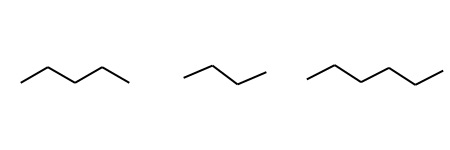
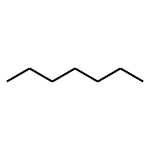
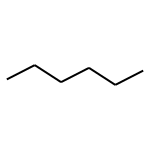
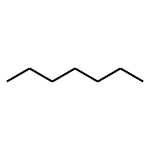
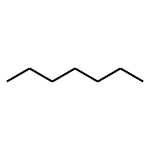
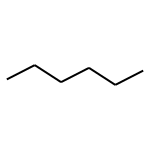
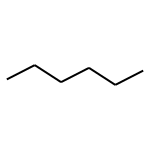
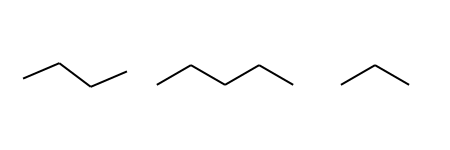
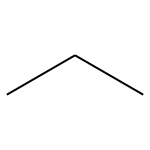
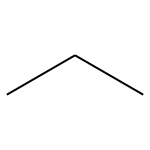
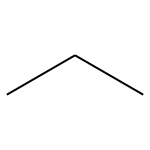
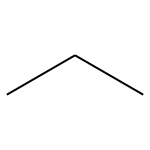
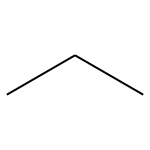
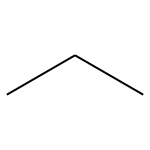
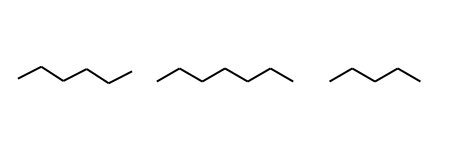
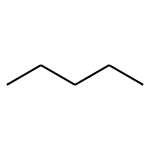
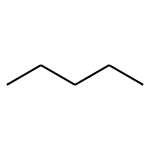
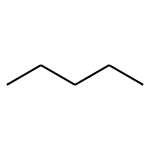
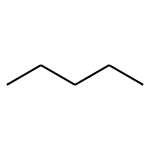
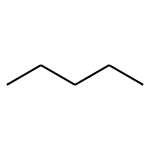
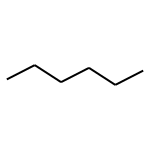
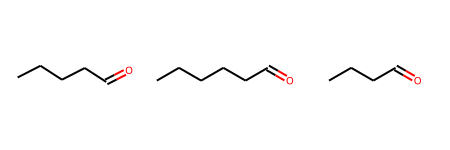
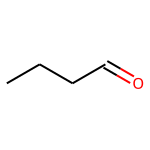
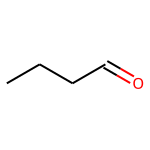
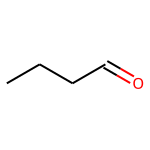
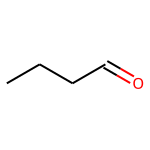
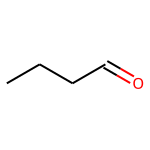
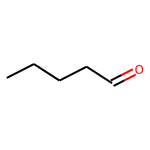
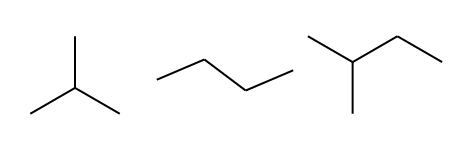
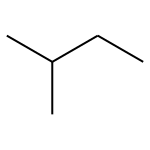
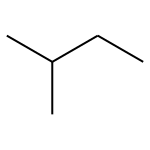
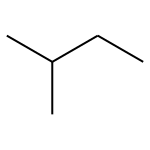
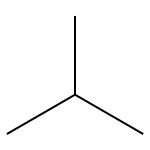
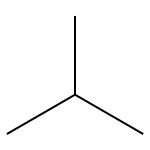
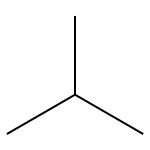
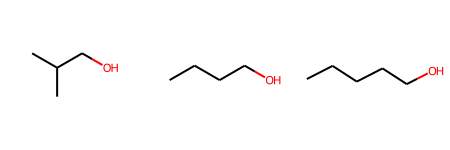
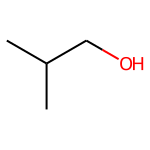
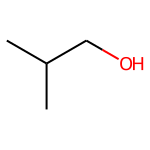
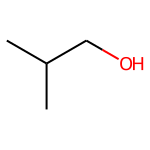
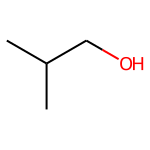
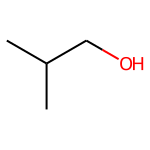
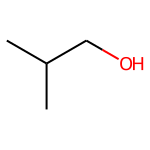
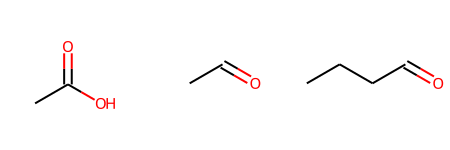
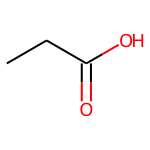
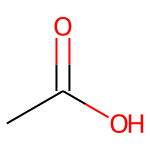
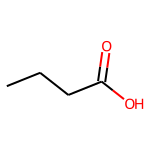
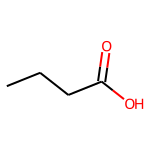
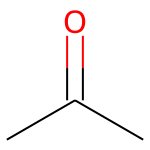
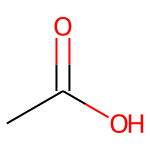
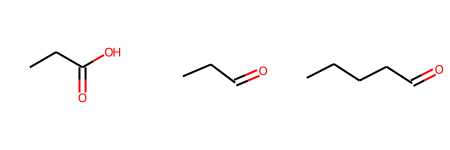
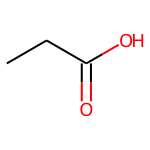
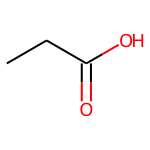
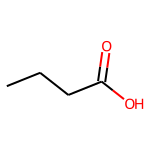
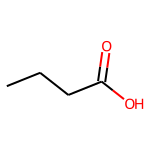
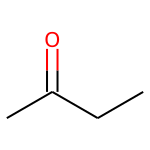
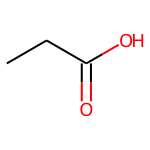
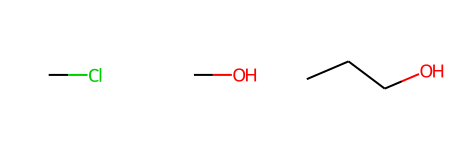
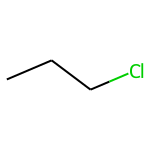
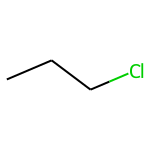
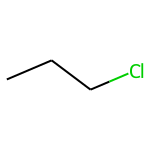
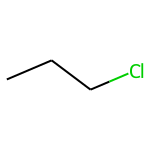
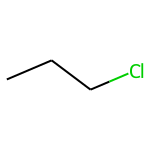
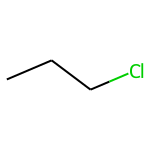
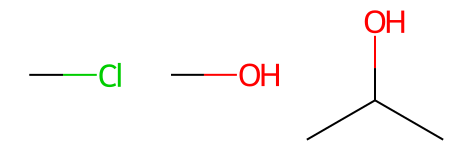
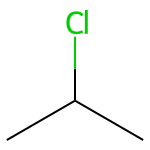
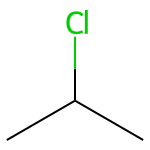
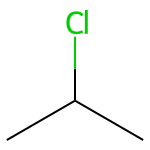
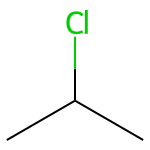
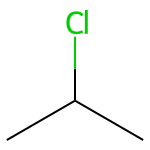
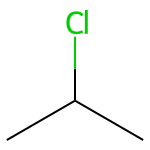
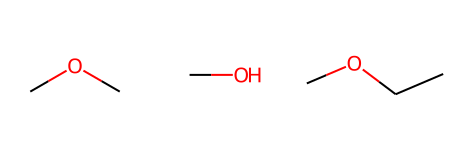
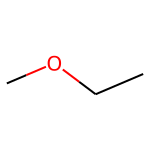
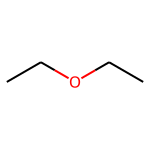
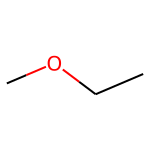
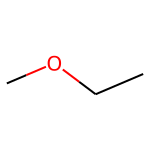
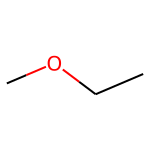
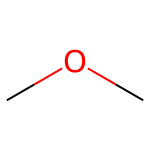

In [50]:
rows = evaluate_operations(operations, embeddings_dict, smiles_to_name, models, skip_input=False)
display_results(rows, models)


In [15]:
# ---- RDKit SVG helpers ----
def mol_to_svg_scaled(smiles, size=(180, 180), bond_length=30):
    """Return RDKit SVG string for a SMILES at fixed bond scale (consistent sizing)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # minimal placeholder tile
        w, h = size
        return f"<svg width='{w}' height='{h}' xmlns='http://www.w3.org/2000/svg'>" \
               f"<rect x='0' y='0' width='{w}' height='{h}' fill='white' stroke='red'/>" \
               f"<text x='{w/2}' y='{h/2}' text-anchor='middle' font-size='14' fill='red'>Invalid</text></svg>"
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    # consistent scale across molecules:
    drawer.drawOptions().fixedBondLength = bond_length
    # (optional) make lines a bit bolder for print
    drawer.drawOptions().bondLineWidth = 2
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # strip XML header to safely nest
    svg = re.sub(r"^\s*<\?xml[^>]*>\s*", "", svg)
    return svg

def svg_inner(svg):
    """Return inner content of an RDKit SVG (strip outer <svg> ... </svg>)."""
    m_open = re.search(r"<svg[^>]*>", svg, flags=re.IGNORECASE | re.DOTALL)
    m_close = re.search(r"</svg>", svg, flags=re.IGNORECASE)
    if not m_open or not m_close:
        return svg  # fallback
    return svg[m_open.end():m_close.start()]

def svg_rect(x, y, w, h, stroke="none", fill="none", stroke_width=2, rx=8, ry=8):
    return (f"<rect x='{x}' y='{y}' width='{w}' height='{h}' "
            f"fill='{fill}' stroke='{stroke}' stroke-width='{stroke_width}' rx='{rx}' ry='{ry}'/>")

def svg_text(x, y, text, size=14, anchor="middle", weight="normal", fill="#000"):
    t = escape(str(text))
    return (f"<text x='{x}' y='{y}' font-size='{size}' text-anchor='{anchor}' "
            f"font-weight='{weight}' fill='{fill}' font-family='Arial, Helvetica, sans-serif'>{t}</text>")

# ---- Main function: evaluate + render to one big SVG ----
def evaluate_operations_to_svg(
    operations, embeddings_dict, smiles_to_name, models,
    outfile="results.svg",
    tile_size=(180, 180),         # molecule tile (drawing) size
    caption_h=28,                 # text space under each tile
    row_gap=24, col_gap=40,       # gaps between rows/columns
    symbol_gap=16,                # space around '+' and '?'
    margin=(30, 50, 30, 30),      # (left, top, right, bottom) margins
    bond_length=30,               # fixed bond length for consistent scale
    show_headers=True
):
    """
    - operations: list of (A, B, C, expected) using NAMES (not SMILES)
    - embeddings_dict: dict[model][rep] -> ndarray [N x D] aligned with smiles_to_name.values() order
    - smiles_to_name: dict[SMILES] -> NAME
    - models: list of (model_key, rep_key)
    - writes a single SVG file (outfile) with rows=operations, columns=[equation] + [predictions per model]
    """
    # Reverse map name -> SMILES
    name_to_smiles = {v: k for k, v in smiles_to_name.items()}

    # Prepare evaluation results for all rows/models
    # Each row_data: {"op": (A,B,C,expected, SA,SB,SC,SEXP), "preds": { (model,rep): (pred_smiles, pred_name, score, correct) } }
    rows_data = []
    all_names = list(smiles_to_name.values())

    for (A, B, C, EXPECTED) in operations:
        SA, SB, SC, SEXP = name_to_smiles[A], name_to_smiles[B], name_to_smiles[C], name_to_smiles[EXPECTED]
        row_entry = {"op": (A, B, C, EXPECTED, SA, SB, SC, SEXP), "preds": {}}

        for (model_key, rep_key) in models:
            # embeddings array aligned with all_names by index
            X = embeddings_dict[model_key][rep_key]  # shape (N, D)
            # map name -> vector
            emb_dict = {name: X[i] for i, name in enumerate(all_names)}          
            
            
            va, vb, vc = emb_dict[A], emb_dict[B], emb_dict[C]
            query = va - vb + vc

            # NN search over NAME keys (exclude A,B,C)
            best_name, best_score = None, -1.0
            for name, vec in emb_dict.items():
                if name in (A, B, C):  # skip the operands
                    continue
                score = cosine_similarity(query.reshape(1, -1), vec.reshape(1, -1))[0][0]
                if score > best_score:
                    best_score = score
                    best_name = name

            pred_smiles = name_to_smiles.get(best_name, best_name)  # fallback to name if unseen
            correct = (pred_smiles == SEXP)
            row_entry["preds"][(model_key, rep_key)] = (pred_smiles, best_name, best_score, correct)

        rows_data.append(row_entry)

    # ---- Layout calculations ----
    n_rows = len(rows_data)
    n_models = len(models)
    tile_w, tile_h = tile_size
    cell_h = tile_h + caption_h
    # first column (equation) uses 3 tiles + 2 symbol gaps (+/?); also extra space for symbols between tiles
    eqn_width = 3 * tile_w + 2 * symbol_gap
    # total width: margins + eqn col + gaps + model columns
    total_w = (margin[0] + eqn_width +
               (col_gap if n_models > 0 else 0) +
               n_models * tile_w +
               (n_models - 1) * col_gap +
               margin[2])
    # total height
    total_h = (margin[1] +
               n_rows * cell_h +
               (n_rows - 1) * row_gap +
               margin[3] +
               (30 if show_headers else 0))

    # ---- Build SVG ----
    svg_parts = [f"<svg xmlns='http://www.w3.org/2000/svg' width='{total_w}' height='{total_h}'>"]
    # background
    svg_parts.append(svg_rect(0, 0, total_w, total_h, fill="white", stroke="none"))

    # Column headers
    start_y = margin[1] + (30 if show_headers else 0)
    if show_headers:
        # First column title:
        svg_parts.append(svg_text(margin[0] + eqn_width / 2, margin[1], "A - B + C", size=16, weight="bold"))
        # Model headers:
        for j, (model_key, rep_key) in enumerate(models):
            x = margin[0] + eqn_width + col_gap + j * (tile_w + col_gap) + tile_w / 2
            svg_parts.append(svg_text(x, margin[1], f"{model_key} | {rep_key}", size=14))

    # Draw each row
    for i, row in enumerate(rows_data):
        (A, B, C, EXPECTED, SA, SB, SC, SEXP) = row["op"]
        y0 = start_y + i * (cell_h + row_gap)
        # ---- Equation column: A ? B + C (three tiles + symbols)
        # positions of three tiles inside equation column
        xA = margin[0]
        xB = margin[0] + tile_w + symbol_gap
        xC = margin[0] + 2 * (tile_w + symbol_gap)

        # tiles (SVG molecules)
        svgA = mol_to_svg_scaled(SA, size=tile_size, bond_length=bond_length)
        svgB = mol_to_svg_scaled(SB, size=tile_size, bond_length=bond_length)
        svgC = mol_to_svg_scaled(SC, size=tile_size, bond_length=bond_length)

        # place tiles by translating inner content
        svg_parts.append(f"<g transform='translate({xA},{y0})'>{svg_inner(svgA)}</g>")
        svg_parts.append(f"<g transform='translate({xB},{y0})'>{svg_inner(svgB)}</g>")
        svg_parts.append(f"<g transform='translate({xC},{y0})'>{svg_inner(svgC)}</g>")

        # symbols between tiles
        mid_y = y0 + tile_h / 2 + 5
        svg_parts.append(svg_text(xA + tile_w + symbol_gap / 2, mid_y, "-", size=22, weight="bold"))
        svg_parts.append(svg_text(xB + tile_w + symbol_gap / 2, mid_y, "+", size=22, weight="bold"))

        # captions under A, B, C
        svg_parts.append(svg_text(xA + tile_w / 2, y0 + tile_h + 18, A, size=12))
        svg_parts.append(svg_text(xB + tile_w / 2, y0 + tile_h + 18, B, size=12))
        svg_parts.append(svg_text(xC + tile_w / 2, y0 + tile_h + 18, C, size=12))

        # ---- Prediction columns
        for j, (model_key, rep_key) in enumerate(models):
            x = margin[0] + eqn_width + col_gap + j * (tile_w + col_gap)
            pred_smiles, pred_name, score, correct = row["preds"][(model_key, rep_key)]
            svgP = mol_to_svg_scaled(pred_smiles, size=tile_size, bond_length=bond_length)
            # tile
            svg_parts.append(f"<g transform='translate({x},{y0})'>{svg_inner(svgP)}</g>")
            # border highlight
            border_color = "#2ecc71" if correct else "#cccccc"
            svg_parts.append(svg_rect(x, y0, tile_w, tile_h, stroke=border_color, stroke_width=4, fill="none", rx=10, ry=10))
            # caption: name + similarity
            label = f"{pred_name}  (cos={score:.3f})"
            svg_parts.append(svg_text(x + tile_w / 2, y0 + tile_h + 18, label, size=12))

    svg_parts.append("</svg>")
    svg = "\n".join(svg_parts)

    # write file
    with open(outfile, "w", encoding="utf-8") as f:
        f.write(svg)
    print(f"? Wrote SVG to {outfile}")

    return svg  # also return the SVG string if you want to display inline


In [52]:
svg = evaluate_operations_to_svg(
    operations, embeddings_dict, smiles_to_name,
    models=models,
    outfile="analogy_results.svg",
    bond_length=30,         # constant scale across all drawings
    tile_size=(180,180),
    show_headers=True
)


? Wrote SVG to analogy_results.svg


In [16]:
def plot_4x4_cosine(embeddings_dict, smiles_to_name, models):
    """
    Plot a 2x2 grid of cosine similarity heatmaps (all vs all molecules)
    for each combination of model & representation.
    
    Args:
        embeddings_dict: dict[model][rep] -> array of shape (N, D)
        smiles_to_name: dict[SMILES] -> molecule name
        models: list of tuples [(model_key, rep_key), ...]
    """
    all_names = list(smiles_to_name.values())
    n_models = len(set([m for m, r in models]))
    n_reps = len(set([r for m, r in models]))
    
    fig, axes = plt.subplots(n_reps, n_models, figsize=(6*n_models, 5*n_reps))

    if axes.ndim == 1:  # ensure 2D array
        axes = axes.reshape(n_reps, n_models)

    for i, rep_key in enumerate(sorted(set([r for m, r in models]))):
        for j, model_key in enumerate(sorted(set([m for m, r in models]))):
            # aligned embeddings for all molecules
            X = embeddings_dict[model_key][rep_key]  # shape (N, D)
            emb_dict = {name: X[idx] for idx, name in enumerate(all_names)}
            vectors = [emb_dict[name] for name in all_names]

            # compute cosine similarity
            sim_matrix = cosine_similarity(vectors)
            df = pd.DataFrame(sim_matrix, index=all_names, columns=all_names)

            # plot heatmap
            ax = axes[i, j]
            sns.heatmap(df, annot=False, cmap="viridis", ax=ax, square=True, vmin=0, vmax=1)
            ax.set_title(f"{model_key} ({rep_key})", fontsize=12)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

def plot_3x2_cosine(embeddings_dict, smiles_to_name, models):
    """
    Plot a 2x2 grid of cosine similarity heatmaps (all vs all molecules)
    for each combination of model & representation.
    
    Args:
        embeddings_dict: dict[model][rep] -> array of shape (N, D)
        smiles_to_name: dict[SMILES] -> molecule name
        models: list of tuples [(model_key, rep_key), ...]
    """
    all_names = list(smiles_to_name.values())
    n_models = len(set([m for m, r in models]))
    n_reps = len(set([r for m, r in models]))
    
    fig, axes = plt.subplots(n_reps, n_models, figsize=(6*n_models, 5*n_reps))

    if axes.ndim == 1:  # ensure 2D array
        axes = axes.reshape(n_reps, n_models)

    for i, rep_key in enumerate(sorted(set([r for m, r in models]))):
        for j, model_key in enumerate(sorted(set([m for m, r in models]))):
            # aligned embeddings for all molecules
            X = embeddings_dict[model_key][rep_key]  # shape (N, D)
            emb_dict = {name: X[idx] for idx, name in enumerate(all_names)}
            vectors = [emb_dict[name] for name in all_names]

            # compute cosine similarity
            sim_matrix = cosine_similarity(vectors)
            df = pd.DataFrame(sim_matrix, index=all_names, columns=all_names)

            # plot heatmap
            ax = axes[i, j]
            sns.heatmap(df, annot=False, cmap="viridis", ax=ax, square=True, vmin=0, vmax=1)
            ax.set_title(f"{model_key} ({rep_key})", fontsize=12)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

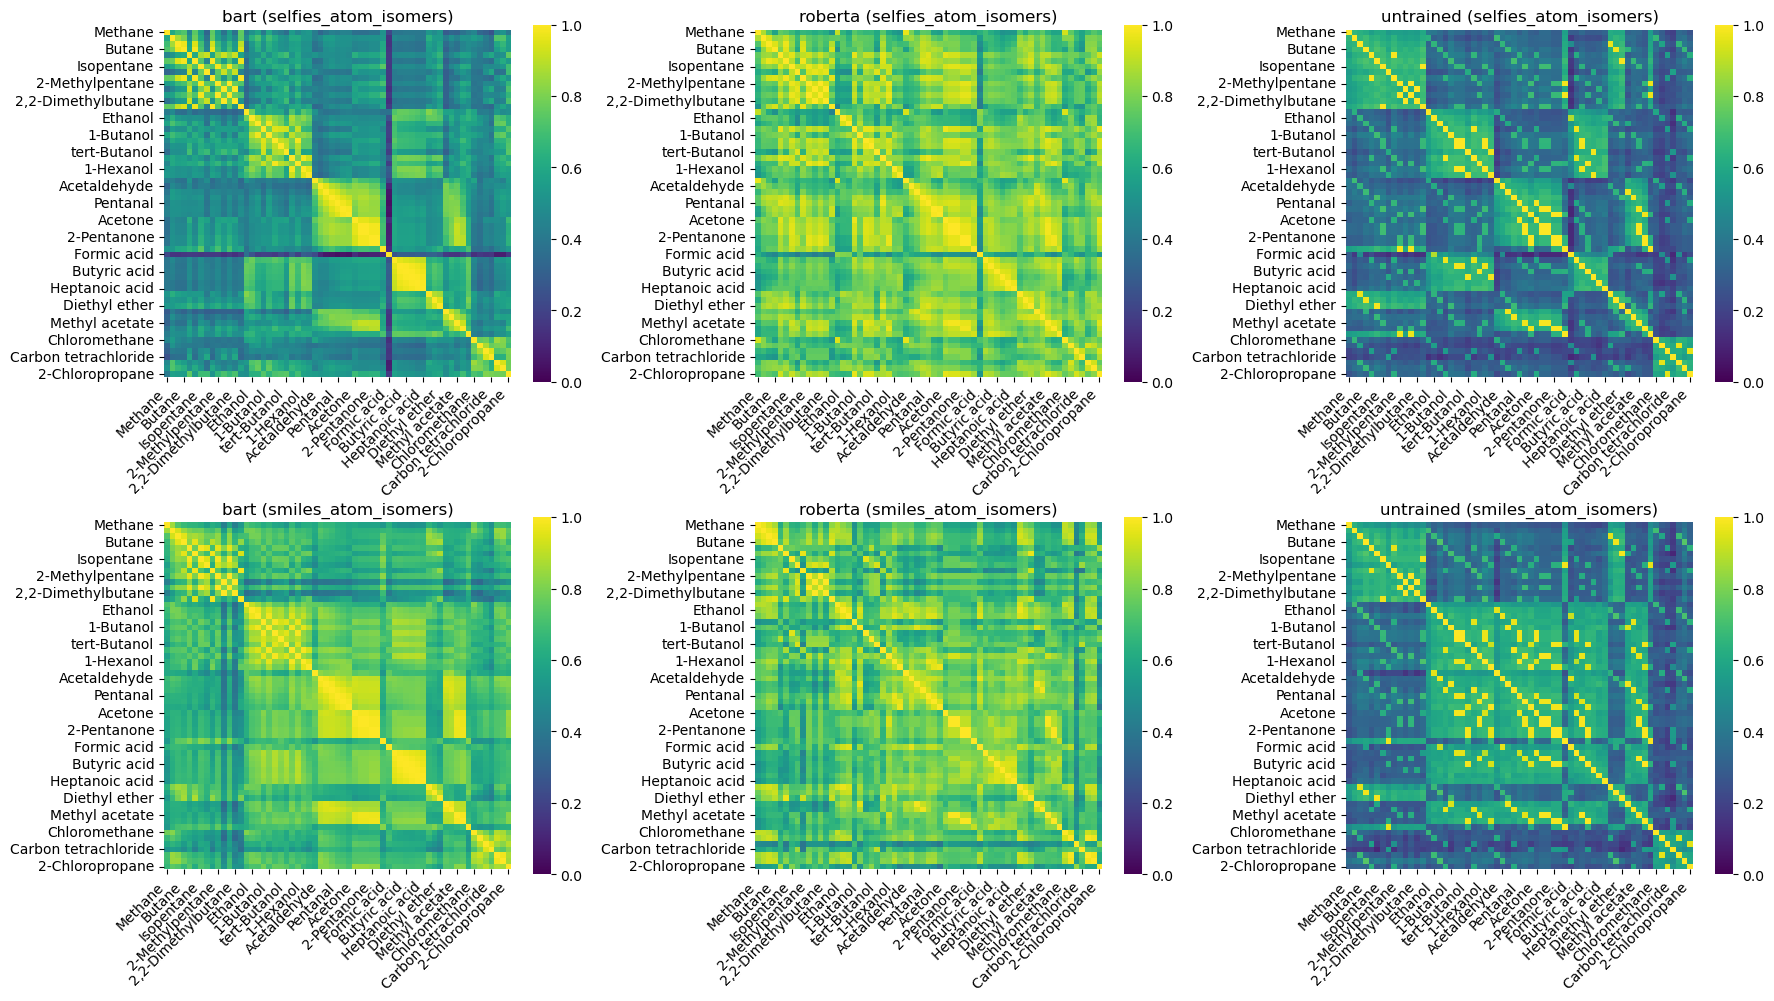

In [22]:
models = [
    ('roberta', 'selfies_atom_isomers'),
    ('roberta', 'smiles_atom_isomers'),
    ('bart', 'selfies_atom_isomers'),
    ('bart', 'smiles_atom_isomers'),
    ('untrained', 'smiles_atom_isomers'),
    ('untrained', 'selfies_atom_isomers')
]

plot_3x2_cosine(embeddings_dict, smiles_to_name, models)

In [18]:
from sklearn.linear_model import Lasso

def decompose_molecule(
    target_name: str, 
    embeddings_dict: Dict, 
    smiles_to_name: Dict, 
    model_key: str, 
    rep_key: str, 
    top_k: int = 5, 
    alpha: float = 0.01
):
    """
    Decomposes a target molecule's embedding into a linear combination of other
    molecule embeddings using Lasso regression.

    Args:
        target_name (str): The name of the molecule to decompose.
        embeddings_dict (Dict): The dictionary containing molecule embeddings.
        smiles_to_name (Dict): The dictionary mapping SMILES to names.
        model_key (str): The key for the model (e.g., 'roberta').
        rep_key (str): The key for the representation (e.g., 'selfies_atom_standard').
        top_k (int): The number of top contributing molecules to display.
        alpha (float): The regularization strength for the Lasso model.
    """
    all_names = np.array(list(smiles_to_name.values()))
    all_embeddings = np.array(embeddings_dict[model_key][rep_key])
    
    try:
        target_idx = np.where(all_names == target_name)[0][0]
    except IndexError:
        print(f"Error: Target molecule '{target_name}' not found.")
        return

    # Create a mask to exclude the target molecule's data
    indices_mask = np.ones(len(all_names), dtype=bool)
    indices_mask[target_idx] = False
    
    # X_train contains the embeddings of all other molecules
    X_train = all_embeddings[indices_mask]
    
    # y_target is the embedding of the target molecule
    y_target = all_embeddings[target_idx]

    # Fit Lasso model. Transpose data to fit Lasso's requirements
    # (n_samples, n_features) becomes (n_dims, n_molecules)
    model = Lasso(alpha=alpha, fit_intercept=False, positive=True, tol=1e-5, max_iter=10000)
    model.fit(X_train.T, y_target) # Note: no transpose needed for y_target
    
    # Get the coefficients and normalize them to sum to 1
    coef = model.coef_
    if np.sum(coef) != 0:
        normalized_coef = coef / np.sum(coef)
    else:
        print("Warning: Sum of coefficients is zero. Normalization skipped.")
        normalized_coef = coef
    
    # Find the indices of the top-k contributing molecules
    top_indices = np.argsort(normalized_coef)[-top_k:][::-1]

    # Reconstruct and print the decomposition string
    decomposition_string = f"Target molecule: {target_name}\nLinear combination: "
    
    # Get the names of the training molecules using the mask
    training_names = all_names[indices_mask]
    
    for idx in top_indices:
        contributor_name = training_names[idx]
        coefficient_value = normalized_coef[idx]
        if coefficient_value > 0:
            decomposition_string += f"{coefficient_value:.3f} * {contributor_name} + "
            
    print(decomposition_string.rstrip(" + "))


In [19]:
#model_key = "roberta"
model_key = "bart"
#rep_key = "selfies_atom_standard"
rep_key = "smiles_atom_standard"
molecules_to_decompose = [
    "Neopentane",
    "2,3-Dimethylbutane",
    "2-Butanol",
    "3-Pentanone",
    "Heptane",
    "Butyric acid"
]
mol = "Butyric acid"
mol = 'Propanal'
for (model_key,rep_key) in models:
#for mol in molecules_to_decompose:
    print(f'{model_key} :: {rep_key}')
    decompose_molecule(mol, embeddings_dict, smiles_to_name, model_key, rep_key)


roberta :: selfies_atom_standard
Target molecule: Propanal
Linear combination: 0.416 * Butanal + 0.355 * Acetaldehyde + 0.074 * Propane + 0.055 * 2-Pentanone + 0.034 * Heptanoic acid
roberta :: smiles_atom_standard
Target molecule: Propanal
Linear combination: 0.356 * Acetaldehyde + 0.258 * 1-Butanol + 0.176 * Hexanal + 0.151 * Methyl formate + 0.046 * Butanal
bart :: selfies_atom_standard
Target molecule: Propanal
Linear combination: 0.608 * Butanal + 0.363 * Acetaldehyde + 0.022 * 1-Chloropropane + 0.007 * Methane
bart :: smiles_atom_standard
Target molecule: Propanal
Linear combination: 0.709 * Butanal + 0.109 * 1-Propanol + 0.093 * Methyl formate + 0.050 * 1-Chloropropane + 0.039 * Acetone
untrained :: smiles_atom_isomers
Target molecule: Propanal
Linear combination: 0.505 * 1-Butanol + 0.480 * Methyl formate + 0.009 * Hexanoic acid + 0.007 * Butanal
untrained :: selfies_atom_isomers
Target molecule: Propanal
Linear combination: 0.758 * Methyl formate + 0.058 * Butane + 0.054 * Hex

In [20]:
def decompose_molecule(
    target_name: str, 
    embeddings_dict: Dict, 
    smiles_to_name: Dict, 
    model_key: str, 
    rep_key: str, 
    top_k: int = 5, 
    alpha: float = 0.01
) -> Dict[str, Any]:
    """
    Decomposes a target molecule's embedding into a linear combination of other
    molecule embeddings using Lasso regression and returns the result as a dict.
    """
    all_names = np.array(list(smiles_to_name.values()))
    all_embeddings = np.array(embeddings_dict[model_key][rep_key])
    
    try:
        target_idx = np.where(all_names == target_name)[0][0]
    except IndexError:
        print(f"Error: Target molecule '{target_name}' not found.")
        return None

    indices_mask = np.ones(len(all_names), dtype=bool)
    indices_mask[target_idx] = False
    
    X_train = all_embeddings[indices_mask]
    y_target = all_embeddings[target_idx]

    model = Lasso(alpha=alpha, fit_intercept=False, positive=True, tol=1e-5, max_iter=10000)
    model.fit(X_train.T, y_target)
    
    coef = model.coef_
    if np.sum(coef) != 0:
        normalized_coef = coef / np.sum(coef)
    else:
        normalized_coef = coef
    
    top_indices = np.argsort(normalized_coef)[-top_k:][::-1]
    
    decomposition_string = f"Target molecule: {target_name}\nLinear combination: "
    
    training_names = all_names[indices_mask]
    
    for idx in top_indices:
        contributor_name = training_names[idx]
        coefficient_value = normalized_coef[idx]
        if coefficient_value > 0:
            decomposition_string += f"{coefficient_value:.3f} * {contributor_name} + "
            
    return {
        'target': target_name,
        'decomposition': decomposition_string.rstrip(" + ")
    }

# ---- Visualization Function  ----
def visualize_decompositions_to_svg(
    decompositions: Dict[str, Any],
    smiles_to_name: Dict[str, str],
    outfile: str = "decompositions.svg",
    tile_size: Tuple[int, int] = (180, 180),
    caption_h: int = 28,
    row_gap: int = 24, col_gap: int = 40,
    margin: Tuple[int, int, int, int] = (30, 50, 30, 30),
    bond_length: int = 30,
    show_headers: bool = True
):
    """
    Renders molecule decompositions into a single SVG file.
    """
    name_to_smiles = {v: k for k, v in smiles_to_name.items()}
    
    n_rows = len(decompositions)
    tile_w, tile_h = tile_size
    cell_h = tile_h + caption_h
    
    max_decomp_length = 0
    for data in decompositions.values():
        parts = data['decomposition'].split('Linear combination: ')[1].split(' + ')
        if len(parts) > max_decomp_length:
            max_decomp_length = len(parts)

    num_columns = 1 + max_decomp_length
    total_w = (margin[0] + num_columns * tile_w + (num_columns - 1) * col_gap + margin[2])
    total_h = (margin[1] + n_rows * cell_h + (n_rows - 1) * row_gap + margin[3] + (30 if show_headers else 0))

    svg_parts = [f"<svg xmlns='http://www.w3.org/2000/svg' width='{total_w}' height='{total_h}'>"]
    svg_parts.append(svg_rect(0, 0, total_w, total_h, fill="white", stroke="none"))

    start_y = margin[1] + (30 if show_headers else 0)
    if show_headers:
        svg_parts.append(svg_text(margin[0] + tile_w / 2, margin[1], "Target Molecule", size=16, weight="bold"))
        for j in range(max_decomp_length):
            x = margin[0] + (j + 1) * (tile_w + col_gap) + tile_w / 2
            svg_parts.append(svg_text(x, margin[1], f"Component {j+1}", size=14))

    row_idx = 0
    for model_key, data in decompositions.items():
        y0 = start_y + row_idx * (cell_h + row_gap)
        model_label = " :: ".join(model_key.split(' :: ')[0:2])
        #svg_parts.append(svg_text(margin[0] / 2, y0 + tile_h / 2, model_key, size=14, anchor="start", weight="bold"))
        # Modified with rotation:
        text_x_pos = margin[0] / 2
        text_y_pos = y0 + tile_h / 2
        svg_parts.append(
        f"<g transform='translate({text_x_pos},{text_y_pos}) rotate(-90)'>"
        f"{svg_text(0, 0, model_label, size=14, anchor='middle', weight='bold')}" # Anchor middle and (0,0) for text within rotated group
        f"</g>"
        )
        target_name = data['target']
        target_smiles = name_to_smiles.get(target_name)
        svg_target = mol_to_svg_scaled(target_smiles, size=tile_size, bond_length=bond_length)
        
        xA = margin[0]
        svg_parts.append(f"<g transform='translate({xA},{y0})'>{svg_inner(svg_target)}</g>")
        svg_parts.append(svg_text(xA + tile_w / 2, y0 + tile_h + 18, target_name, size=12, weight="bold"))

        equals_x = xA + tile_w + col_gap / 2
        svg_parts.append(svg_text(equals_x, y0 + tile_h / 2, "=", size=22, weight="bold"))
        
        parts = data['decomposition'].split('Linear combination: ')[1].split(' + ')
        
        for j, part in enumerate(parts):
            try:
                coefficient_str, mol_name = part.strip().split(' * ')
                mol_smiles = name_to_smiles.get(mol_name)
                
                x = margin[0] + (j + 1) * (tile_w + col_gap)
                
                svg_mol = mol_to_svg_scaled(mol_smiles, size=tile_size, bond_length=bond_length)
                svg_parts.append(f"<g transform='translate({x},{y0})'>{svg_inner(svg_mol)}</g>")
                
                label = f"{float(coefficient_str):.3f} * {mol_name}"
                svg_parts.append(svg_text(x + tile_w / 2, y0 + tile_h + 18, label, size=12))
                
            except ValueError:
                continue
        row_idx += 1
        
    svg_parts.append("</svg>")
    svg = "\n".join(svg_parts)

    with open(outfile, "w", encoding="utf-8") as f:
        f.write(svg)
    print(f"SVG file '{outfile}' created successfully.")

    return svg

# ----  Main Function ----
def create_decomposition_visualization(
    target_molecules: List[str],
    models: List[Tuple[str, str]],
    embeddings_dict: Dict,
    smiles_to_name: Dict,
    outfile: str = "decompositions.svg",
    top_k: int = 5,
    alpha: float = 0.01
):
    """
    Orchestrates the decomposition and visualization process for multiple models and target molecules.

    Args:
        target_molecules (List[str]): List of molecule names to decompose.
        models (List[Tuple[str, str]]): List of (model_key, rep_key) tuples.
        embeddings_dict (Dict): The full dictionary of all molecule embeddings.
        smiles_to_name (Dict): The dictionary mapping SMILES to names.
        outfile (str): The name of the output SVG file.
        top_k (int): The number of top contributing molecules to display.
        alpha (float): The regularization strength for the Lasso model.
    """
    decompositions_data = {}
    
    for target_name in target_molecules:
        for model_key, rep_key in models:
            result = decompose_molecule(
                target_name=target_name,
                embeddings_dict=embeddings_dict,
                smiles_to_name=smiles_to_name,
                model_key=model_key,
                rep_key=rep_key,
                top_k=top_k,
                alpha=alpha
            )
            if result:
                decompositions_data[f"{model_key} :: {rep_key} :: {target_name}"] = result

    # Call the visualization function with the generated data
    visualize_decompositions_to_svg(decompositions_data, smiles_to_name, outfile=outfile)

In [21]:
create_decomposition_visualization(["Butyric acid", 'Propanal'], models, embeddings_dict, smiles_to_name,"decompositions.svg")

SVG file 'decompositions.svg' created successfully.
